In [138]:
%matplotlib inline
%load_ext lab_black

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import missingno as msno
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
import tensorflow as tf
import IPython
from sklearn.base import BaseEstimator, RegressorMixin, clone

from shared import process_single_site, compute_metrics
from plot import (
    plot_timeline,
    plot_desity_and_errors,
    pred_plot,
    error_per_month_and_year,
)
from shared import HistoryKerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from tensorflow import keras
from model import eval_model, make_grid, hyperparam_graph, hyperparam_plot
import missingno as msno
from shared import daylength, solar_altitude
from sklearn.model_selection import train_test_split
from extra import ding

resources = "resources/"

data_path = os.path.join(resources, "data.csv.gz")
metadata_path = os.path.join(resources, "fdk_site_info.csv")
test_path = os.path.join(resources, "full_time_series.csv.gz")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# LSTM

In [76]:
# Loading the selected data
df = pd.read_csv(data_path)
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
# We add time derived features
df["month"] = df["TIMESTAMP"].dt.month
df["year"] = df["TIMESTAMP"].dt.year
df["day_of_year"] = df["TIMESTAMP"].dt.dayofyear
# We set the sitename and date as indexes
df.set_index(["sitename", "TIMESTAMP"], drop=False, inplace=True)
df.index.names = ["site", "date"]

if df.index.duplicated().sum() > 0:
    raise Error("Duplicated index!")

print(f"Number of sites: {len(df.index.get_level_values(0).unique())}")
print(f"Sample count: {len(df)}")

Number of sites: 58
Sample count: 221353


In [77]:
df

TIMESTAMP     P_F    P_F_QC   TA_F_MDS  TA_F_MDS_QC  \
site   date                                                              
CA-Ca1 1996-01-01 1996-01-01   6.438  0.000000  11.304479     0.000000   
       1996-01-02 1996-01-02  11.906  0.000000  12.214603     0.000000   
       1996-01-03 1996-01-03   0.352  0.000000  10.456395     0.000000   
       1996-01-04 1996-01-04   0.096  0.000000   7.384063     0.000000   
       1996-01-05 1996-01-05  19.444  0.000000   7.804625     0.000000   
...                      ...     ...       ...        ...          ...   
US-xYE 2021-12-27 2021-12-27   1.688  0.020833 -10.867395     0.958333   
       2021-12-28 2021-12-28   0.522  0.020833 -15.326292     1.000000   
       2021-12-29 2021-12-29   1.325  0.104167 -13.713897     1.000000   
       2021-12-30 2021-12-30   3.014  0.000000 -11.464873     1.000000   
       2021-12-31 2021-12-31   1.898  0.020833 -16.116521     1.000000   

                   TMIN_F_MDS  TMAX_F_MDS  SW_IN_F_MDS  SW_IN_F_MDS_QC  \
site   date                                                              
CA-Ca1 1996-01-01   11.304479   11.304479     4.914229          0.0000   
       1996-01-02   12.214603   12.214603     5.458479          0.0000   
       1996-01-03   10.456395   10.456395    42.828855          0.0000   
       1996-01-04    7.384063    7.384063    37.207834          0.0000   
       1996-01-05    7.804625    7.804625    25.735646          0.0000   
...                       ...         ...          ...             ...   
US-xYE 2021-12-27  -10.867395  -10.867395    36.374000          0.9375   
       2021-12-28  -15.326292  -15.326292    50.194146          1.0000   
       2021-12-29  -13.713897  -13.713897    49.436667          1.0000   
       2021-12-30  -11.464873  -11.464873    29.889791          1.0000   
       2021-12-31  -16.116521  -16.116521    51.740834          1.0000   

                   LW_IN_F_MDS  ...  LE_CORR_JOINTUNC  H_CORR_JOINTUNC  \
site   date                     ...                                      
CA-Ca1 1996-01-01   335.451040  ...               NaN              NaN   
       1996-01-02   344.627542  ...               NaN              NaN   
       1996-01-03   279.785915  ...               NaN              NaN   
       1996-01-04   246.538499  ...               NaN              NaN   
       1996-01-05   283.211794  ...               NaN              NaN   
...                        ...  ...               ...              ...   
US-xYE 2021-12-27   250.971918  ...               NaN              NaN   
       2021-12-28   216.418229  ...               NaN              NaN   
       2021-12-29   230.894229  ...               NaN              NaN   
       2021-12-30   247.889584  ...               NaN              NaN   
       2021-12-31   206.756250  ...               NaN              NaN   

                        LAI      FPAR  TA_DAY_F_MDS  VPD_DAY_F_MDS  sitename  \
site   date                                                                    
CA-Ca1 1996-01-01  0.888925  0.596234     11.313749       1.340125    CA-Ca1   
       1996-01-02  0.892857  0.594424     12.657684       1.742000    CA-Ca1   
       1996-01-03  0.897188  0.592706     10.984001       3.241750    CA-Ca1   
       1996-01-04  0.901892  0.591178      7.667940       3.095500    CA-Ca1   
       1996-01-05  0.906941  0.589936      8.090187       2.055938    CA-Ca1   
...                     ...       ...           ...            ...       ...   
US-xYE 2021-12-27  0.222626  0.136456    -10.715912       0.722853    US-xYE   
       2021-12-28  0.221317  0.135284    -15.272941       0.613545    US-xYE   
       2021-12-29  0.220151  0.134182    -13.871124       0.582537    US-xYE   
       2021-12-30  0.219171  0.133171    -11.434462       0.627073    US-xYE   
       2021-12-31  0.218424  0.132272    -15.647322       0.434357    US-xYE   

                   month  year  day_of_year  
site   date                                

In [78]:
def windowed_mask(d, m, mask_name="mask"):
    def g(x, n):
        return x.sum() == n

    def r(d, n):
        return d[mask_name].rolling(n, step=n).apply(lambda x: g(x, n))

    windowed_mask_name = mask_name + "_window"
    d[windowed_mask_name] = r(d, m)
    d[windowed_mask_name] = d[windowed_mask_name].shift(1 - m)
    d[windowed_mask_name].ffill(limit=m - 1, inplace=True)
    return d

In [79]:
MAX_WINDOW = 64
val_performance = {}
performance = {}

In [80]:
d = df.copy()

d["GPP"] = d[["GPP_NT_VUT_REF", "GPP_DT_VUT_REF"]].mean(axis=1, skipna=False)

discarded_features = [
    "NETRAD",
    "SW_OUT",
    "USTAR",
    "NEE_VUT_REF",
    "RECO_NT_VUT_REF",
    "H_CORR",
    "LE_CORR",
    "H_CORR_JOINTUNC",
    "LE_CORR_JOINTUNC",
    "NETRAD_QC",
    "USTAR_QC",
    "H_CORR_QC",
    "LE_CORR_QC",
    "TMIN_F_MDS",
    "TMAX_F_MDS",
]
d.drop(discarded_features, inplace=True, axis=1)

# Replace values lower than a limit with NA:
def nullate_lower_than(d, field, limit=-9998):
    d.loc[d[field] <= limit, field] = np.nan


# The dataset documentation tells us that some features may use `-9999` as a placeholder for missing value.
for f in d.select_dtypes(include="number").columns:
    nullate_lower_than(d, f)

nullate_lower_than(d, "PA_F", 0)

print(len(d))
na_check_columns = [
    c for c in d.columns.values if not (c.endswith("_JOINTUNC") or c.endswith("_QC"))
]
qc_threshold = 0.5
f_qc_check = ["TA_F_MDS_QC", "SW_IN_F_MDS_QC", "VPD_F_MDS_QC", "NEE_VUT_REF_QC"]
bad_data_mask = (d[f_qc_check] < qc_threshold).any(axis=1)
d["mask"] = (~bad_data_mask) & (~d[na_check_columns].isnull().any(axis=1))
print(d["mask"].sum())
d = d.groupby("site").apply(lambda x: windowed_mask(x.droplevel(0), MAX_WINDOW))
d = d[d["mask_window"] == 1]

site_df = pd.read_csv(metadata_path, index_col="sitename")
df_join = d.join(site_df[["lat"]], on="sitename")
d["lat"] = df_join["lat"]
d["day_length"] = d.apply(lambda x: daylength(x["day_of_year"], x["lat"]), axis=1)
d["solar_altitude"] = d.apply(
    lambda x: solar_altitude(x["day_of_year"], x["lat"]), axis=1
)
d["apar"] = d["SW_IN_F_MDS"] * d["FPAR"]
d["TA_F_MDS**2"] = (d["TA_F_MDS"] + 41) ** 2

excluded_features = [
    "CO2_F_MDS",  # As explained above
    "GPP_DT_VUT_REF",  # Already included in GPP
    "GPP_NT_VUT_REF",  # Already included in GPP
    "GPP_diff",
    "TIMESTAMP",
    "sitename",
    "lat",
    "day_of_year",
    "month",
    "year",
    "mask",
    "mask_window",
    "VPD_DAY_F_MDS",
    "TA_DAY_F_MDS",
]


def features(data):
    return [f for f in data.columns.values if not f.endswith("_QC")]


working_features = [f for f in features(d) if f not in excluded_features]
df_prep = d[working_features].copy()
df_prep.info()

221353
166403
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 89152 entries, ('CA-Ca1', Timestamp('1998-02-08 00:00:00')) to ('US-xTA', Timestamp('2021-11-28 00:00:00'))
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   P_F             89152 non-null  float64
 1   TA_F_MDS        89152 non-null  float64
 2   SW_IN_F_MDS     89152 non-null  float64
 3   LW_IN_F_MDS     89152 non-null  float64
 4   VPD_F_MDS       89152 non-null  float64
 5   WS_F            89152 non-null  float64
 6   PA_F            89152 non-null  float64
 7   LE_F_MDS        89152 non-null  float64
 8   H_F_MDS         89152 non-null  float64
 9   LAI             89152 non-null  float64
 10  FPAR            89152 non-null  float64
 11  GPP             89152 non-null  float64
 12  day_length      89152 non-null  float64
 13  solar_altitude  89152 non-null  float64
 14  apar            89152 non-null  float64
 15  TA_F_MDS**2     89152 non

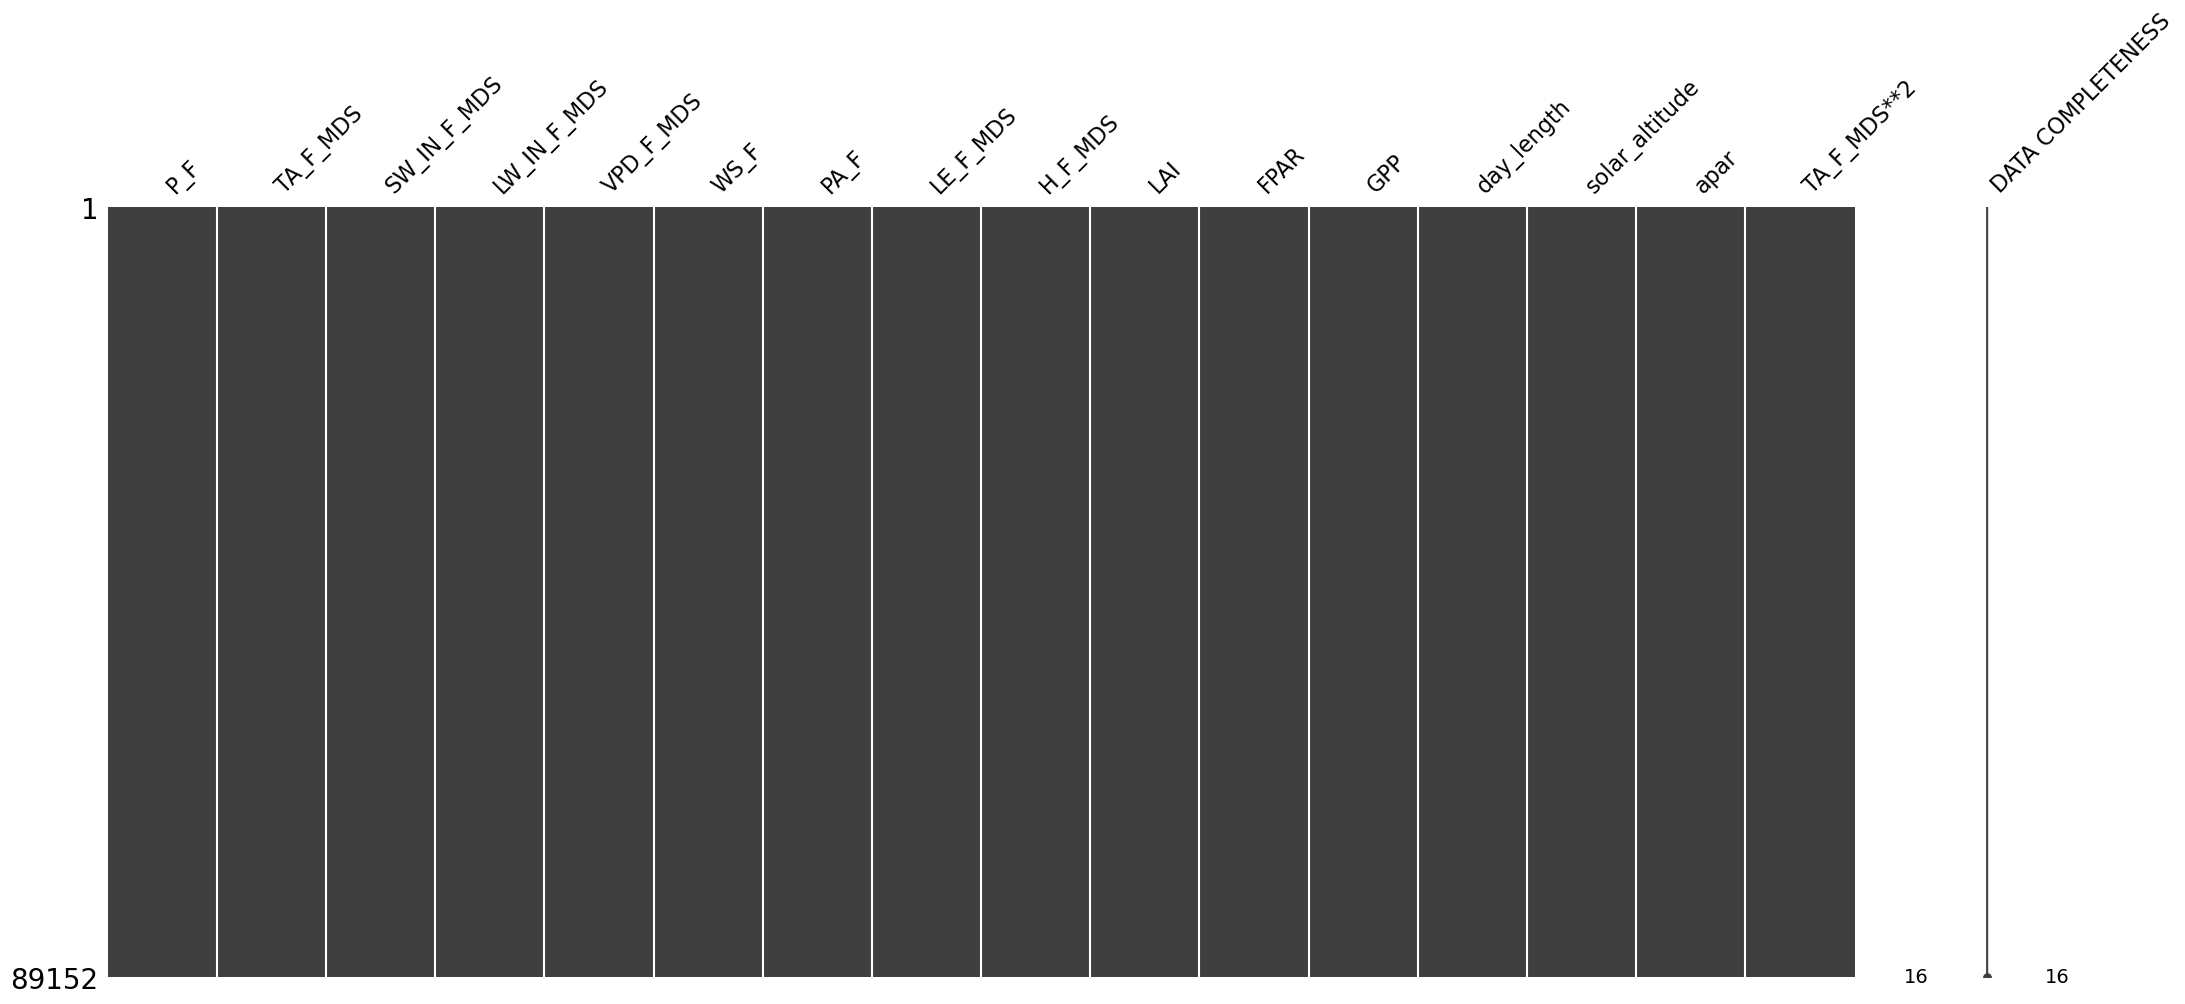

In [81]:
msno.matrix(df_prep, labels=True)
plt.show()

In [82]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift=0,  # Offset following the end of the input section marking the end of the label section.
        label_columns=["GPP"],
        keep_labels=False,  # Keep label columns as input features (autocorrelation)
        batch_size=8,
        shuffle=False,
    ):
        if shift == 0 and keep_labels is True:
            raise Error("shift must be positive if keep_labels is True")

        self.keep_labels = keep_labels
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.total_window_size = input_width + shift
        if MAX_WINDOW % self.total_window_size != 0:
            raise Exception(
                f"total_window_size ({self.total_window_size}) must be a divider of MAX_WINDOW ({MAX_WINDOW})"
            )
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.shifted_label_indices = np.arange(self.total_window_size)[
            self.labels_slice
        ]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.shifted_label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def indep_columns(self, columns):
        return [c for c in columns if (c not in self.label_columns) or self.keep_labels]

    def column_indices(self, columns):
        return {name: i for i, name in enumerate(columns)}

    # Given a batch of consecutive inputs, convert them to a window of inputs and a window of labels.
    def split_window(self, features, columns):
        inputs = features[:, self.input_slice, :]
        shifted_labels = features[:, self.labels_slice, :]
        self.column_indices(columns)
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    inputs[:, :, self.column_indices(columns)[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )
            inputs = tf.stack(
                [
                    inputs[:, :, self.column_indices(columns)[name]]
                    for name in self.indep_columns(columns)
                ],
                axis=-1,
            )
            shifted_labels = tf.stack(
                [
                    shifted_labels[:, :, self.column_indices(columns)[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.input_width, None])
        shifted_labels.set_shape([None, self.label_width, None])

        return inputs, labels, shifted_labels

    # Predict window n of first batch only
    # Attention, not NaN padded!
    def predict(
        self,
        data,
        model,
        n=0,
        plot_col=None,
        is_baseline=False,
    ):
        if plot_col is None:
            plot_col = self.label_columns[0]
        inputs, labels, shifted_labels = next(iter(self.make_dataset_intern(data)))
        if is_baseline:
            inputs = labels
        label_col_index = self.label_columns_indices.get(plot_col, None)

        predictions = model(inputs)
        return predictions[n, :, label_col_index].numpy()

    # Plot first batch only (and at most max_subplots windows)
    def plot(
        self,
        data,
        model=None,
        plot_col=None,
        max_subplots=1,
        is_baseline=False,
    ):
        if plot_col is None:
            plot_col = self.label_columns[0]
        inputs, labels, shifted_labels = next(iter(self.make_dataset_intern(data)))
        if is_baseline:
            inputs = labels
        plt.figure(figsize=(12, 8))
        label_col_index = self.label_columns_indices.get(plot_col, None)
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                labels[n, :, label_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if model is None:
                plt.scatter(
                    self.shifted_label_indices,
                    shifted_labels[n, :, label_col_index],
                    edgecolors="k",
                    label="Labels",
                    c="#2ca02c",
                    s=64,
                )
            else:
                predictions = model(inputs)
                plt.scatter(
                    self.shifted_label_indices,
                    predictions[n, :, label_col_index],
                    # marker="X",
                    # edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=16,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Day")
        plt.show()

    # Create an iterator yielding batches of random windows
    def make_dataset_intern(self, data):
        columns = data.columns
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            shuffle=self.shuffle,
            batch_size=self.batch_size,
            sequence_stride=self.total_window_size,
        )

        ds = ds.map(lambda f: self.split_window(f, columns))

        return ds

    def make_dataset(self, data, return_labels_as_feature=False):
        if return_labels_as_feature:
            return self.make_dataset_intern(data).map(lambda x, y, z: (y, z))
        else:
            return self.make_dataset_intern(data).map(lambda x, y, z: (x, z))

In [83]:
def plot_curves(history):
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.title(
        "Validation loss {:.3f}".format(np.mean(history.history["val_loss"][-3:]))
    )
    plt.xlabel("epoch")
    plt.ylabel("loss value")
    plt.legend()
    plt.show()

In [84]:
def compile_and_fit(model, window, learning_rate=0.001, max_epochs=100, patience=6):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.make_dataset(train_df),
        epochs=max_epochs,
        validation_data=window.make_dataset(val_df),
        callbacks=[early_stopping],
    )
    return history

In [85]:
def build_and_test(name, model, window, is_baseline=False):
    if is_baseline is True:
        max_epochs = 0
    else:
        max_epochs = 100
    history = compile_and_fit(model, window, max_epochs=max_epochs)
    if max_epochs > 1:
        plot_curves(history)

    val_performance[name] = model.evaluate(
        window.make_dataset(val_df, is_baseline), return_dict=True
    )
    performance[name] = model.evaluate(
        window.make_dataset(test_df, is_baseline), verbose=0, return_dict=True
    )
    print(f"Val: {val_performance[name]}")
    print(f"Test: {performance[name]}")

In [116]:
tv_cut = 0.8
array = df_prep.to_numpy().reshape(-1, MAX_WINDOW, 16)
A_tv, A_test = train_test_split(array, train_size=tv_cut)
split_tv = pd.DataFrame(A_tv.reshape(-1, 16), columns=df_prep.columns.values)
split_test = pd.DataFrame(A_test.reshape(-1, 16), columns=df_prep.columns.values)
X_tv = split_tv.drop(["GPP"], axis=1)
y_tv = split_tv["GPP"]
X_test = split_test.drop(["GPP"], axis=1)
y_test = split_test["GPP"]
print(X_tv.shape)
print(X_test.shape)
df_pred = pd.DataFrame()
df_pred["True GPP"] = y_test.copy()
df_pred["baseline"] = df_pred["True GPP"]

(71296, 15)
(17856, 15)


Loading the data
Loading metadata and joining
Adding GPP and GPP_diff
Dropping unused features
Removing bad values
Adding engineered features
Remove unused features
NA: 48


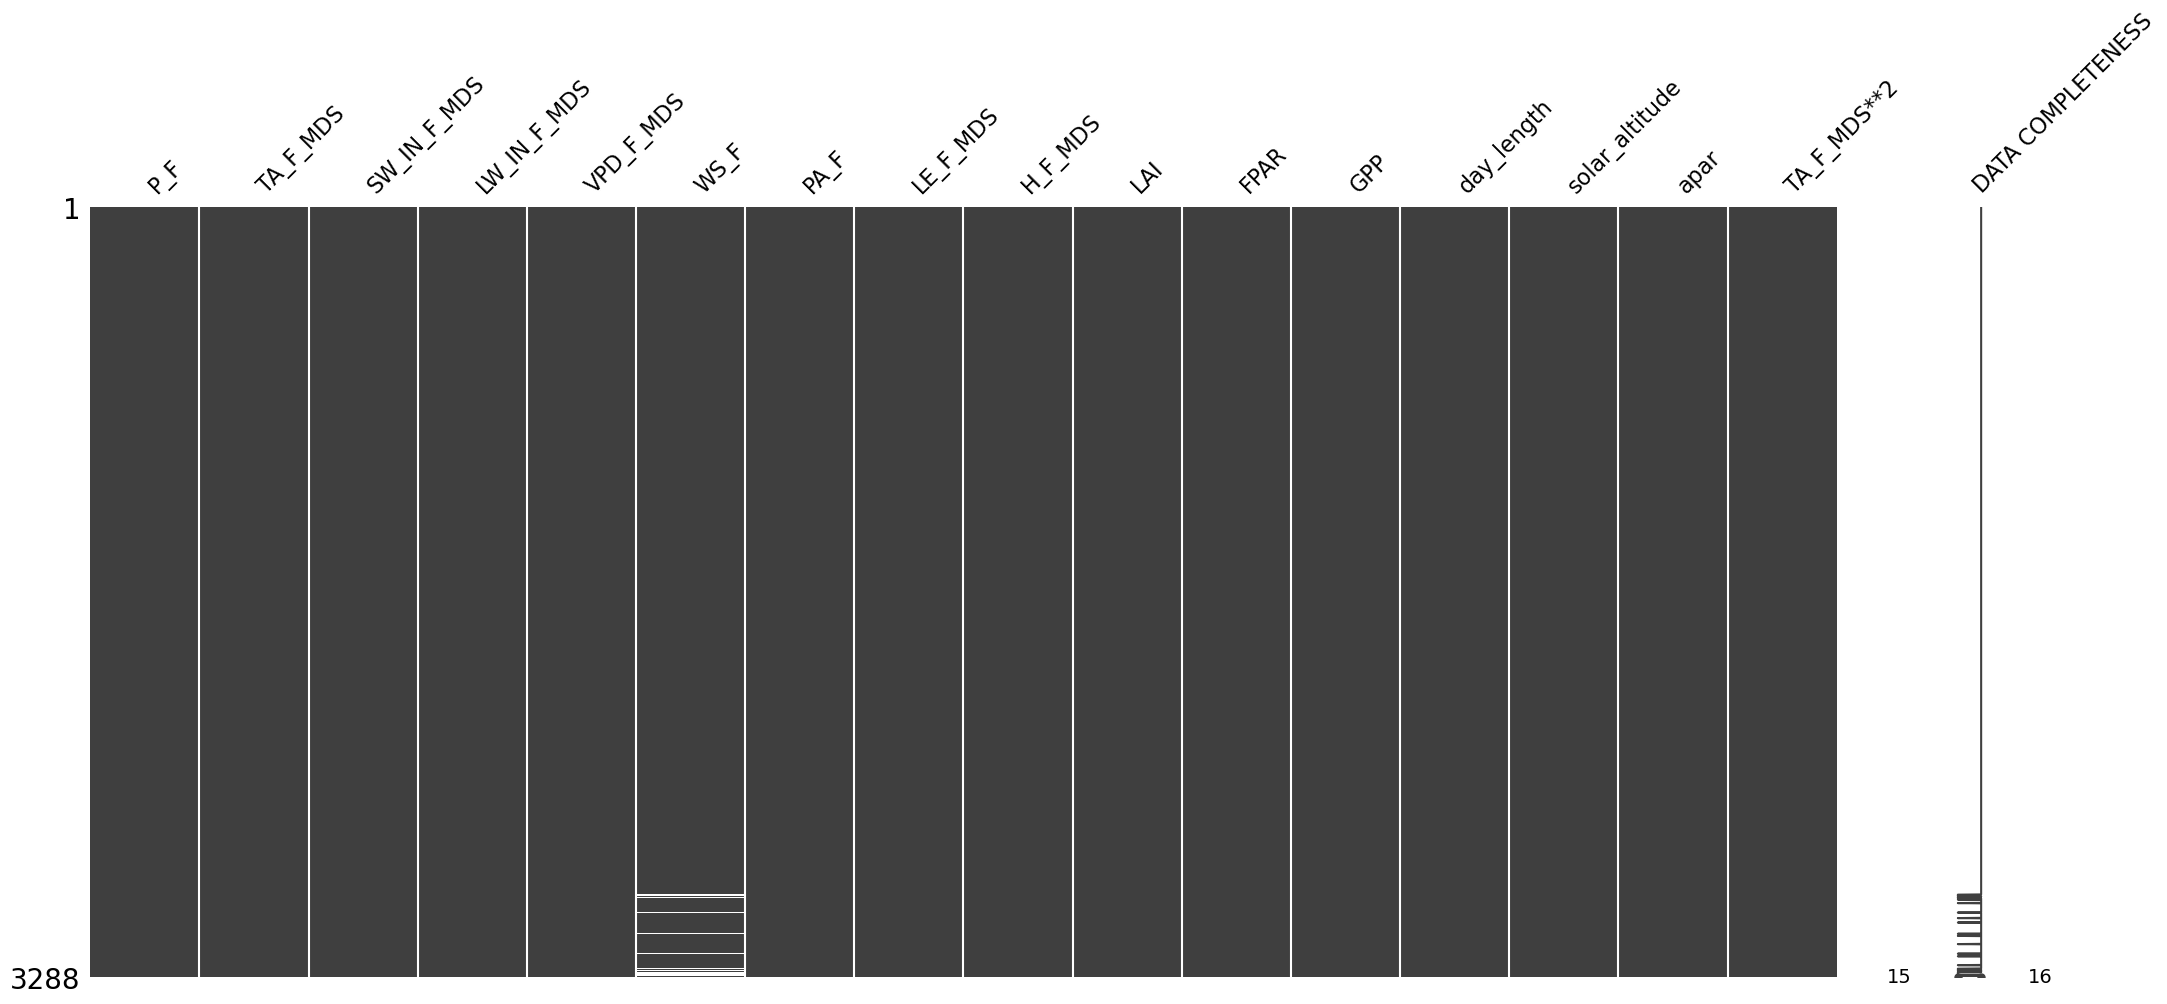

In [118]:
df_test = process_single_site(test_path, metadata_path, with_rolling_windows=False)

In [119]:
df_test["WS_F"].fillna(df_test["WS_F"].mean(), inplace=True)
print(f"NA: {(df_test.isna().any(axis=1)).sum()}")
df_test.describe()
print(df_test.shape)
# It must be a multiple of 64
new_size = (len(df_test) // MAX_WINDOW) * MAX_WINDOW
df_test = df_test.head(new_size)
print(df_test.shape)

df_pred_test = pd.DataFrame()
df_pred_test["True GPP"] = df_test["GPP"].copy()

NA: 0
(3288, 16)
(3264, 16)


In [120]:
class WindowRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self, regressor, n=1, batch_size=8, shuffle=False, validation_split=0.2
    ):
        self.regressor = regressor
        self.n = n
        self.validation_split = validation_split
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.window = WindowGenerator(n, n, batch_size=batch_size, shuffle=shuffle)

    def fit(self, X, y, verbose=False):
        X = pd.DataFrame(X)
        X["GPP"] = y
        cut = 1 - self.validation_split
        train_size = int((len(X) * cut) // MAX_WINDOW) * MAX_WINDOW
        X_train, X_val = train_test_split(X, train_size=train_size, shuffle=False)
        val_batches = self.window.make_dataset(X_val)
        if len(val_batches) <= 0:
            raise Error(
                "Increase validation_split so that there are enough samples to fit at least one window."
            )
        self.regressor.fit(
            self.window.make_dataset(X_train),
            None,
            validation_data=val_batches,
        )

        # Return the estimator
        return self

    def predict(self, X):
        w_size = min(MAX_WINDOW, len(X))
        window = WindowGenerator(
            w_size, w_size, batch_size=self.batch_size, shuffle=False
        )
        X = pd.DataFrame(X)
        X["GPP"] = 0
        batches = window.make_dataset(X)
        if len(batches) <= 0:
            raise Exception(
                "The set to be predicted does not contain enough samples to fit at least one window."
            )
        pred = self.regressor.predict(batches)
        return pred.flatten()

In [121]:
def model_fun(
    lstm_units,
    learning_rate,
    dropout=0,
    recurrent_dropout=0,
    kernel_regularizer=0,
    recurrent_regularizer=0,
    seed=0,
):
    model = tf.keras.models.Sequential(
        [
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(
                lstm_units,
                return_sequences=True,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                kernel_regularizer=tf.keras.regularizers.L2(kernel_regularizer),
                recurrent_regularizer=tf.keras.regularizers.L2(recurrent_regularizer),
                # seed=seed
            ),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1),
        ]
    )
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )
    # model.summary()
    return model

In [122]:
def build_model():
    regressor = WindowRegressor(
        HistoryKerasRegressor(
            model_fun,
            verbose=1,
            shuffle=False,
            epochs=100,
            callbacks=[keras.callbacks.EarlyStopping(patience=4, mode="min")],
        ),
        n=1,
    )
    return regressor

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Epoch 1/100
223/223 [==============================] - 4s 13ms/step - loss: 0.4515 - mean_absolute_error: 0.5106 - val_loss: 0.3398 - val_mean_absolute_error: 0.4441
Epoch 2/100
223/223 [==============================] - 2s 11ms/step - loss: 0.3080 - mean_absolute_error: 0.4158 - val_loss: 0.2907 - val_mean_absolute_error: 0.4067
Epoch 3/100
223/223 [==============================] - 2s 11ms/step - loss: 0.2738 - mean_absolute_error: 0.3870 - val_loss: 0.2660 - val_mean_absolute_error: 0.3866
Epoch 4/100
223/223 [==============================] - 2s 11ms/step - loss: 0.2533 - mean_absolute_error: 0.3687 - val_loss: 0.2495 - val_mean_absolute_error: 0.3722
Epoch 5/100
223/223 [==============================] - 2s 11ms/step - loss: 0.2377 - mean_absolute_error: 0.3546 - val_loss: 0.2381 - val_mean_absolute_error: 0.3616
Epoch 6/100
223/223 [==============================] - 2s 11ms/step - loss: 0.2266 - mean_absolute_error: 0.344

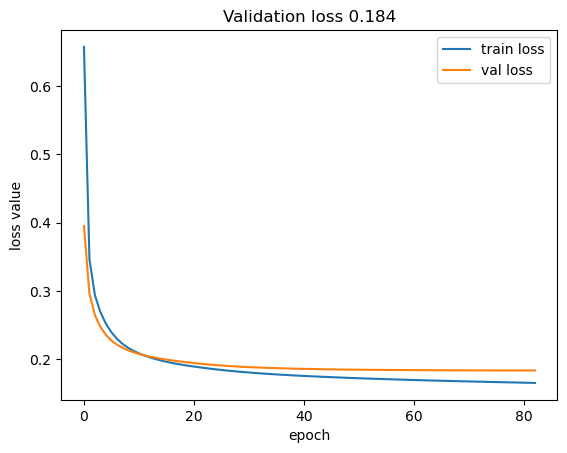

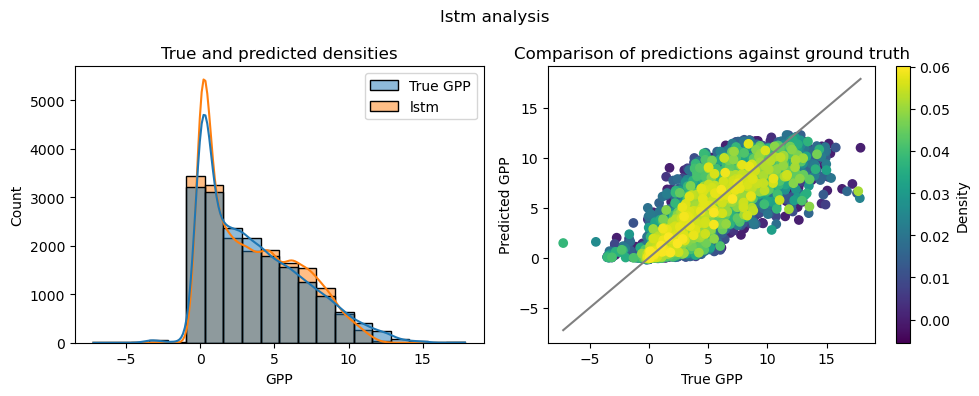

----
Predicting Test...
7/7 [==============================] - 0s 6ms/step
Prediction time: 0.27s
Score (Test): 0.81
MAE (Test): 1.03
RMSE (Test): 2.06


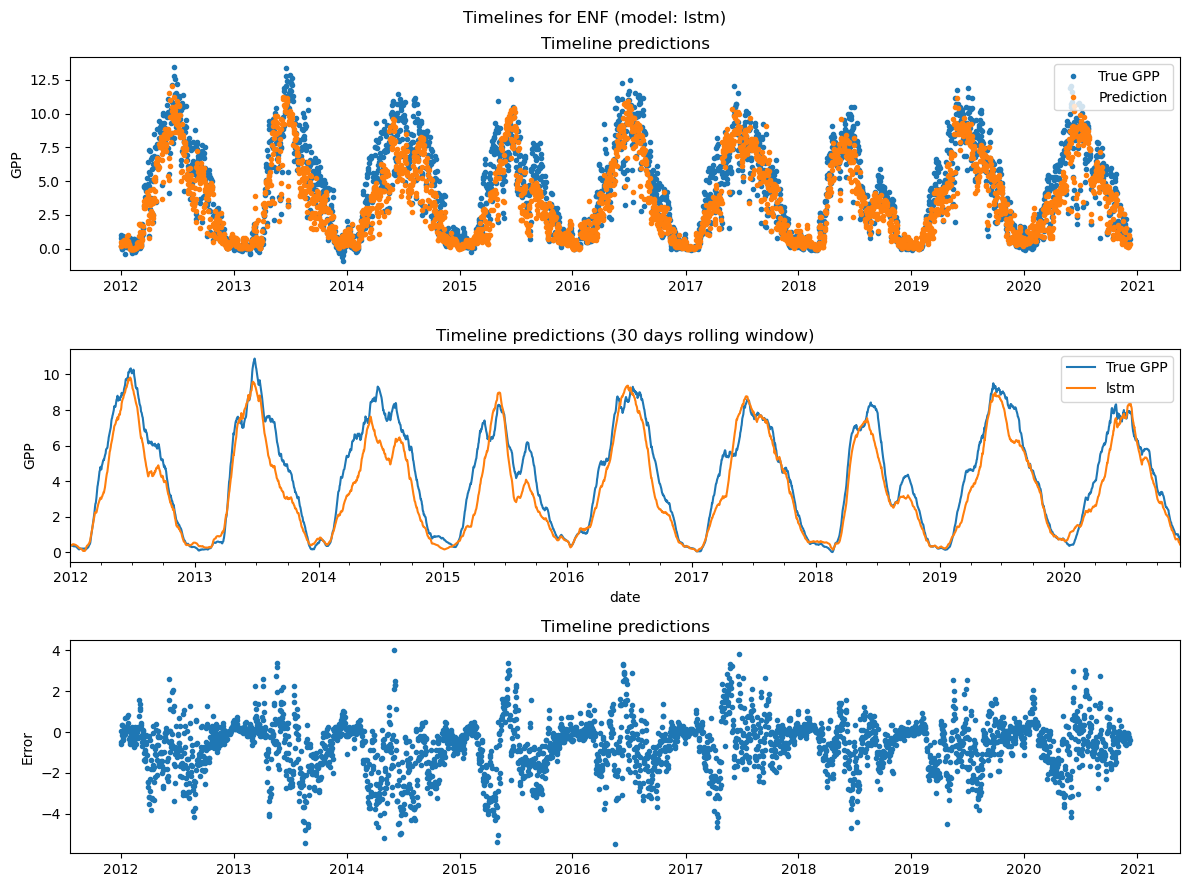

In [127]:
name = "lstm"

grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n": [32],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [5],
        "reg__regressor__epochs": [100],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1,
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
# plot_timeline(df_pred, name, "ENF")
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")

In [ ]:
grid = make_grid(
    [
        QuantileTransformer(output_distribution="normal"),
    ],
    {
        "reg__n": [2, 4, 8, 16, 32, 64],  # Total window size
        "reg__regressor__learning_rate": [0.001],
        "reg__regressor__lstm_units": [1, 2, 3, 4, 5],
        "reg__regressor__epochs": [30],
        "reg__regressor__verbose": [False],
    },
)

model, df_pred[name], pred_time, r2, mae, rmse = eval_model(
    None,
    build_model(),
    grid,
    X_tv,
    y_tv,
    X_test,
    y_test,
    verbose=2,
    n_splits=0,
    n_jobs=1
)
plot_curves(model.best_estimator_.regressor_.named_steps.reg.regressor.history)
hyperparam_graph(model, "reg__n", xlog=True)
hyperparam_graph(model, "reg__regressor__lstm_units", xlog=False)
hyperparam_plot(
    model, ["reg__regressor__lstm_units", "reg__n"])
pred_plot(df_pred, name)
df_pred_test[name], _, _, _, _ = compute_metrics(
    model, df_test.drop(["GPP"], axis=1), df_pred_test["True GPP"], label="Test"
)
plot_timeline(df_pred_test, name, "ENF")
ding("LSTM")

Fitting 1 folds for each of 30 candidates, totalling 30 fits
[CV] END regressor__reg__n=2, regressor__reg__regressor__epochs=30, regressor__reg__regressor__learning_rate=0.001, regressor__reg__regressor__lstm_units=1, regressor__reg__regressor__verbose=False, regressor__scaler=QuantileTransformer(output_distribution='normal'), transformer=QuantileTransformer(output_distribution='normal'); total time= 5.1min
